## preprocess

In [1]:
from collections import Counter
import numpy as np
import sys
import re
import string
import time
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import nltk
from nltk import pos_tag
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from flair.models import TextClassifier
from flair.data import Sentence
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('twitter_sentiments_data.csv',low_memory=False)
df = df[['target','tweet']]
df.sample(5)

,target,tweet
1031568,1,is pleased as fuck with her GPA
527825,0,"Went to bed after 12, didn't sleep well, had t..."
942803,1,@ZDAEfron i love youu youre an amazing actor
48694,0,#hoppusday is dying
995641,1,change is hard but good.


In [6]:
data_pos = df[df['target'] == 1]
data_neg = df[df['target'] == 0]
data_pos_small = data_pos.iloc[:100000]
data_neg_small = data_neg.iloc[:100000]

dataset = pd.concat([data_neg, data_pos])
dataset = pd.concat([data_neg_small, data_pos_small])
data_targets = dataset.drop('tweet',axis = 1)
dataset = dataset.drop('target',axis = 1)

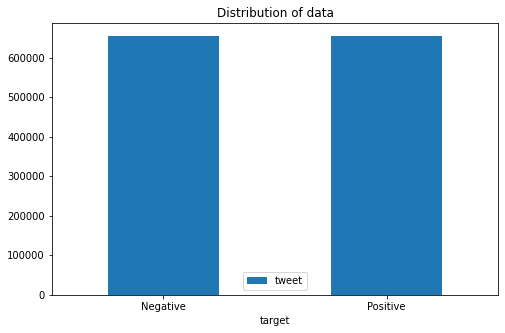

In [4]:
ax = df.groupby('target').count()
ax = ax.plot(kind='bar', figsize = (8,5),title='Distribution of data')
ax.set_xticklabels(['Negative','Positive'], rotation=0)

text, target = list(dataset['tweet']), list(data_targets['target'])

<AxesSubplot:xlabel='target', ylabel='count'>

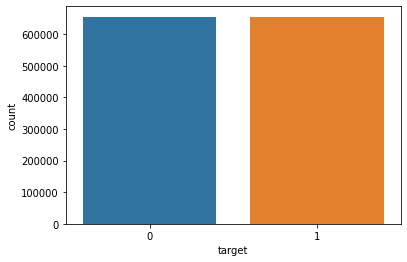

In [10]:
sns.countplot(x = 'target',data=df)

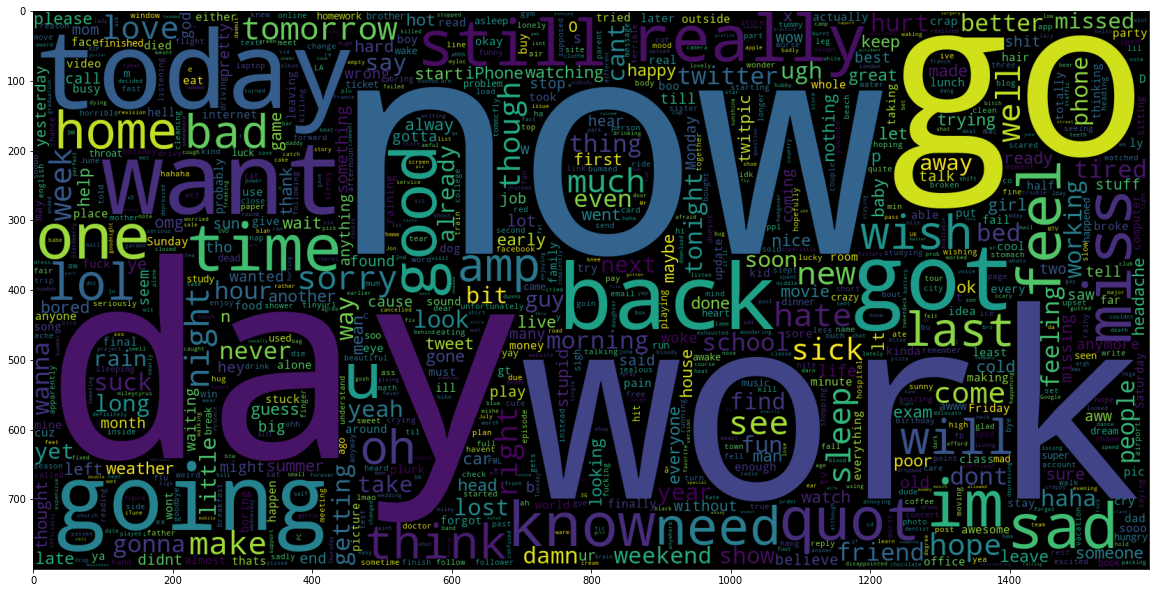

In [7]:
data_neg_cloud = df['tweet'][:len(data_neg)]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg_cloud))
plt.imshow(wc)

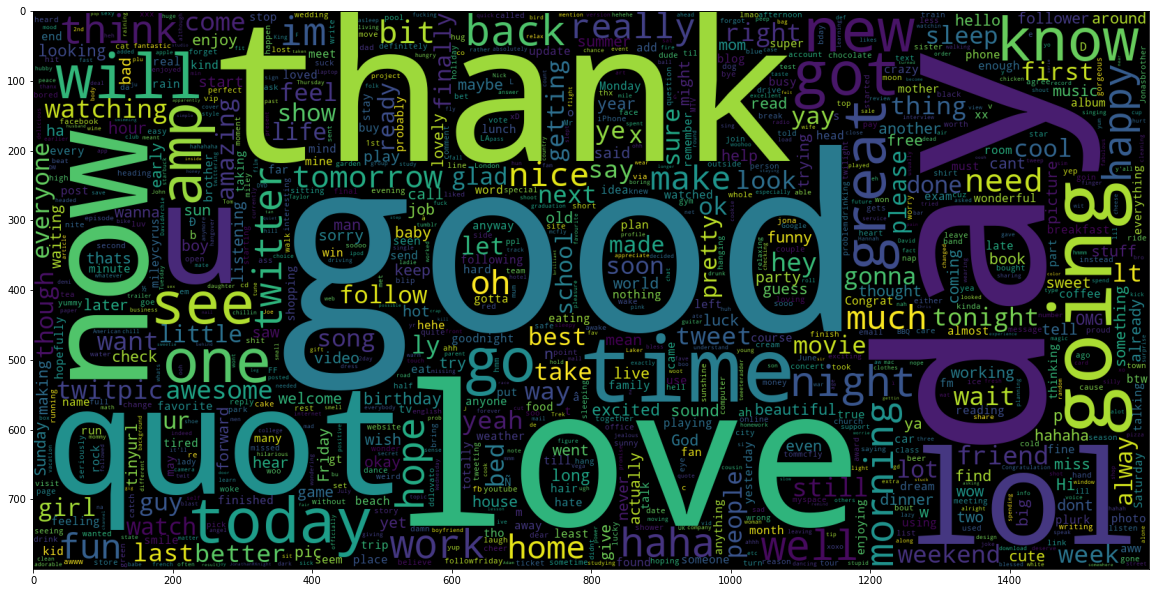

In [8]:
data_pos_cloud = df['tweet'][len(data_neg):]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos_cloud))
plt.imshow(wc)

#### transfer to lower letters

In [11]:
dataset['tweet']=dataset['tweet'].str.lower()
dataset['tweet'].head()

0    is upset that he can't update his facebook by ...
1    @kenichan i dived many times for the ball. man...
2    @nationwideclass no, it's not behaving at all....
3                        @kwesidei not the whole crew 
4                                          need a hug 
Name: tweet, dtype: object

#### clean stopwords

In [12]:
stopwords_new =['i', 'me', 'my', 'myself', 'we', 'our', 'ours', \
 'ourselves', 'you', "you're", "you've", "you'll", \
 "you'd", 'your', 'yours', 'yourself', 'yourselves', \
 'he', 'him', 'his', 'himself', 'she', "she's", 'her',\
 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they',\
 'them', 'their', 'theirs', 'themselves', 'what', 'which', \
 'who', 'whom', 'this', 'that', "that'll", 'these', 'those',\
 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', \
 'have', 'has', 'had', 'having', 'do', 'does', 'did',\
 'doing', 'a', 'an', 'the', 'and', 'if', 'or',  'because', \
 'as',  'of', 'at', 'by', 'for', 'with', 'about',  'between', 'into',\
 'through', 'during', 'before', 'after', 'above', 'below',\
 'to', 'from', 'in', 'out', 'on', 'off', \
 'over', 'under', 'again', 'further', 'then', 'once', \
 'here', 'there', 'when', 'where', 'all', 'any', 'both',\
 'each', 'few', 'more', 'most', 'other',  'some', 'such', 'own', \
 'same', 'so', 'than', 'too', 'very', 's',  \
 'will', 'just', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y']

In [13]:
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwords_new])
dataset['tweet'] = dataset['tweet'].apply(lambda text: cleaning_stopwords(text))
dataset['tweet'].head()

0    upset can't update facebook texting it... migh...
1    @kenichan dived many times ball. managed save ...
2    @nationwideclass no, not behaving all. i'm mad...
3                             @kwesidei not whole crew
4                                             need hug
Name: tweet, dtype: object

#### clean names

In [14]:
def cleaning_names(text):
    return " ".join([word for word in str(text).split() if '@' not in word])
dataset['tweet'] = dataset['tweet'].apply(lambda text: cleaning_names(text))
dataset['tweet'].head()

0    upset can't update facebook texting it... migh...
1    dived many times ball. managed save 50% rest g...
2    no, not behaving all. i'm mad. why here? can't...
3                                       not whole crew
4                                             need hug
Name: tweet, dtype: object

#### clean URLs

In [15]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['tweet'] = dataset['tweet'].apply(lambda x: cleaning_URLs(x))
dataset['tweet'].head()

0    upset can't update facebook texting it... migh...
1    dived many times ball. managed save 50% rest g...
2    no, not behaving all. i'm mad. why here? can't...
3                                       not whole crew
4                                             need hug
Name: tweet, dtype: object

#### clean numbers

In [16]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['tweet'] = dataset['tweet'].apply(lambda x: cleaning_numbers(x))
dataset['tweet'].head()

0    upset can't update facebook texting it... migh...
1    dived many times ball. managed save % rest go ...
2    no, not behaving all. i'm mad. why here? can't...
3                                       not whole crew
4                                             need hug
Name: tweet, dtype: object

#### clean punctuations

In [17]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['tweet']= dataset['tweet'].apply(lambda x: cleaning_punctuations(x))
dataset['tweet'].head()

0    upset cant update facebook texting it might cr...
1    dived many times ball managed save  rest go bo...
2    no not behaving all im mad why here cant see t...
3                                       not whole crew
4                                             need hug
Name: tweet, dtype: object

#### Tokenizer

In [18]:
def Tokenizer(data):
  sentence = [getattr(row,'tweet') for row in data.itertuples()]
  sentence_tokenized = [word_tokenize(sentence[i]) for i in range(len(sentence))]
  return sentence_tokenized
  
sentence_tokenized = Tokenizer(dataset)
sentence_tokenized

[['upset',
  'cant',
  'update',
  'facebook',
  'texting',
  'it',
  'might',
  'cry',
  'result',
  'school',
  'today',
  'also',
  'blah'],
 ['dived', 'many', 'times', 'ball', 'managed', 'save', 'rest', 'go', 'bounds'],
 ['no',
  'not',
  'behaving',
  'all',
  'im',
  'mad',
  'why',
  'here',
  'cant',
  'see',
  'there'],
 ['not', 'whole', 'crew'],
 ['need', 'hug'],
 ['nope', 'didnt'],
 ['que', 'muera'],
 ['spring', 'break', 'plain', 'city', 'snowing'],
 ['repierced', 'ears'],
 ['couldnt', 'bear', 'watch', 'it', 'thought', 'ua', 'loss', 'embarrassing'],
 ['counts', 'idk', 'why', 'either', 'never', 'talk', 'anymore'],
 ['wish', 'got', 'watch', 'you', 'miss', 'how', 'premiere'],
 ['hollis',
  'death',
  'scene',
  'hurt',
  'severely',
  'watch',
  'film',
  'wry',
  'directors',
  'cut',
  'not',
  'now'],
 ['ahh', 'ive', 'always', 'wanted', 'see', 'rent', 'love', 'soundtrack'],
 ['day', 'didnt', 'get', 'much', 'done'],
 ['one',
  'friend',
  'called',
  'me',
  'asked',
  'meet'

#### word lemmatizing

In [19]:
lm = nltk.WordNetLemmatizer()
for sen in sentence_tokenized:
    for word,tag in pos_tag(sen):
        if tag in ['NN','NNS','NNP','NNPS']:#noun
            sen[sen.index(word)] = lm.lemmatize(word, pos='n')
        elif tag in ['VB','VBD','VBG','VBN','VBP','VBZ']:#verb
            sen[sen.index(word)] = lm.lemmatize(word, pos='v')
        elif tag in ['JJ','JJR','JJS']:#adjactive
            sen[sen.index(word)] = lm.lemmatize(word, pos='a')
        elif tag in ['RB','RBR','RBS']:#adverb
            sen[sen.index(word)] = lm.lemmatize(word, pos='r')
        else: continue
sentence_tokenized

[['upset',
  'cant',
  'update',
  'facebook',
  'texting',
  'it',
  'might',
  'cry',
  'result',
  'school',
  'today',
  'also',
  'blah'],
 ['dive', 'many', 'time', 'ball', 'manage', 'save', 'rest', 'go', 'bound'],
 ['no',
  'not',
  'behave',
  'all',
  'im',
  'mad',
  'why',
  'here',
  'cant',
  'see',
  'there'],
 ['not', 'whole', 'crew'],
 ['need', 'hug'],
 ['nope', 'didnt'],
 ['que', 'muera'],
 ['spring', 'break', 'plain', 'city', 'snowing'],
 ['repierced', 'ear'],
 ['couldnt', 'bear', 'watch', 'it', 'think', 'ua', 'loss', 'embarrassing'],
 ['count', 'idk', 'why', 'either', 'never', 'talk', 'anymore'],
 ['wish', 'get', 'watch', 'you', 'miss', 'how', 'premiere'],
 ['hollis',
  'death',
  'scene',
  'hurt',
  'severely',
  'watch',
  'film',
  'wry',
  'director',
  'cut',
  'not',
  'now'],
 ['ahh', 'ive', 'always', 'want', 'see', 'rent', 'love', 'soundtrack'],
 ['day', 'didnt', 'get', 'much', 'do'],
 ['one',
  'friend',
  'call',
  'me',
  'ask',
  'meet',
  'mid',
  'valle

In [20]:
sentence_tokenized= [' '.join(wordlist) for wordlist in sentence_tokenized]

In [21]:
dataset_processed = pd.DataFrame(sentence_tokenized,columns = ['tweet'])

#### clean very commen words

In [22]:
from collections import Counter
positive_counts = Counter()
negative_counts = Counter()
total_counts = Counter()
for review, label in zip(dataset_processed.tweet.values,data_targets.target.values):
    words = review.split(' ')
    total_counts.update(words)
    if label == 1:
        positive_counts.update(words)
    else:
        negative_counts.update(words)

In [23]:
positive_counts.most_common(20)

[('get', 9628),
 ('im', 9058),
 ('go', 8372),
 ('good', 8350),
 ('day', 7460),
 ('love', 6463),
 ('but', 5947),
 ('up', 5017),
 ('like', 4946),
 ('not', 4231),
 ('time', 4175),
 ('thanks', 4156),
 ('well', 4025),
 ('see', 3918),
 ('lol', 3851),
 ('today', 3718),
 ('make', 3510),
 ('think', 3473),
 ('u', 3469),
 ('work', 3448)]

In [24]:
negative_counts.most_common(20)

[('get', 12278),
 ('go', 12123),
 ('im', 12121),
 ('but', 9842),
 ('not', 9335),
 ('work', 7724),
 ('day', 6730),
 ('up', 6475),
 ('no', 6256),
 ('cant', 5454),
 ('dont', 5318),
 ('miss', 5287),
 ('like', 4991),
 ('want', 4834),
 ('today', 4833),
 ('back', 4623),
 ('good', 4167),
 ('feel', 4162),
 ('time', 4019),
 ('think', 3761)]

In [26]:
def cleaning_commen(text):
    return " ".join([word for word in str(text).split() if word not in ['get','go','im','like','up']])
dataset_processed['tweet'] = dataset_processed['tweet'].apply(lambda text: cleaning_commen(text))
dataset_processed['tweet'].head()

0    upset cant update facebook texting it might cr...
1           dive many time ball manage save rest bound
2        no not behave all mad why here cant see there
3                                       not whole crew
4                                             need hug
Name: tweet, dtype: object

In [424]:
pre_save = pd.DataFrame(data_targets).to_csv('data_processed_porj2——tar.csv')

## models

In [28]:
X = dataset_processed.tweet
y  = data_targets.target

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state =990628)
vectoriser = TfidfVectorizer(ngram_range=(1,2),max_features = 3000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))
X_train_tf = vectoriser.transform(X_train)
X_test_tf  = vectoriser.transform(X_test)

No. of feature_words:  3000


In [40]:
from scipy.sparse import hstack
feat_comb_tr = hstack([X_train_tf,X_train_cv])
feat_comb_te = hstack([X_test_tf,X_test_cv])

In [41]:
X_train_tf.toarray().shape

(160000, 3000)

In [42]:
def model_Evaluate(model):
    y_pred = model.predict(X_test_tf)
    print(classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

#### BNB Model

              precision    recall  f1-score   support

           0       0.78      0.74      0.76     20092
           1       0.75      0.79      0.77     19908

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000



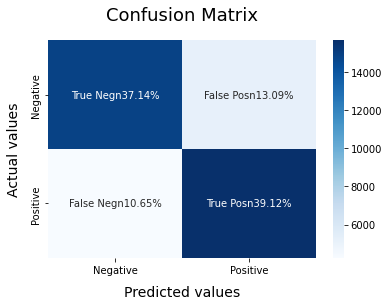

In [45]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train_tf, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test_tf)

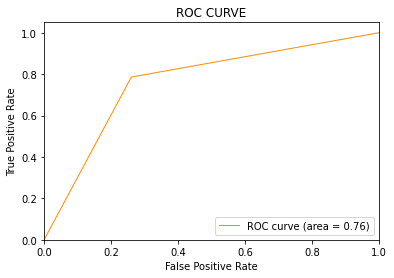

In [46]:
from sklearn.metrics import roc_curve, auc
y_test_int = [int(num) for num in y_test]
y_pred1_int = [int(num) for num in y_pred1]
fpr, tpr, thresholds = roc_curve(y_test_int, y_pred1_int)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [ ]:
df_pre_BNB = vectoriser.transform(dataset_processed_pre.tweet)
y_pred1_BNB = BNBmodel.predict(df_pre_BNB)
pd.DataFrame(y_pred1_BNB).to_csv('BNBresult.csv')

#### Linear SVC

              precision    recall  f1-score   support

           0       0.79      0.75      0.77     20092
           1       0.76      0.80      0.78     19908

    accuracy                           0.78     40000
   macro avg       0.78      0.78      0.78     40000
weighted avg       0.78      0.78      0.78     40000



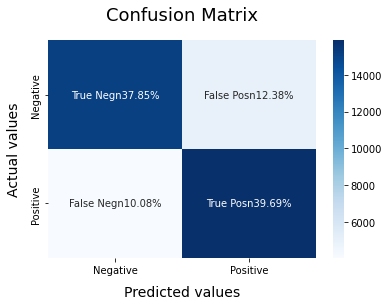

In [49]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train_tf, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test_tf)

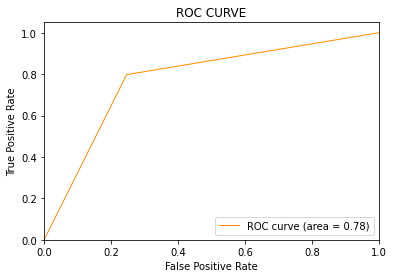

In [50]:
from sklearn.metrics import roc_curve, auc

y_pred2_int = [int(num) for num in y_pred2]
fpr, tpr, thresholds = roc_curve(y_test_int, y_pred2_int)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [54]:
df_pre_SVC = vectoriser.transform(dataset_processed_pre.tweet)
y_pred2_SVC = SVCmodel.predict(df_pre_SVC)
pd.DataFrame(y_pred2_SVC).to_csv('SVCresult.csv')

#### LR model

              precision    recall  f1-score   support

           0       0.79      0.76      0.77     20092
           1       0.77      0.79      0.78     19908

    accuracy                           0.78     40000
   macro avg       0.78      0.78      0.78     40000
weighted avg       0.78      0.78      0.78     40000



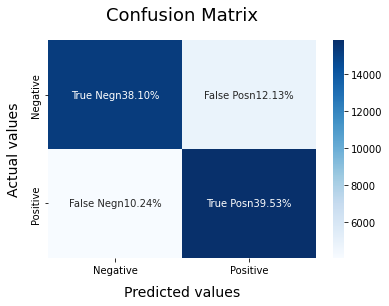

In [54]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train_tf, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test_tf)

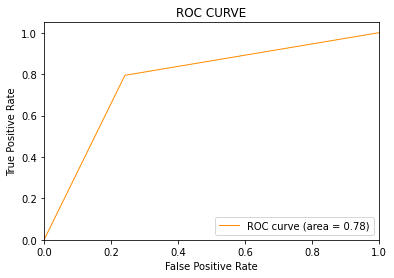

In [55]:
from sklearn.metrics import roc_curve, auc

y_pred3_int = [int(num) for num in y_pred3]
fpr, tpr, thresholds = roc_curve(y_test_int, y_pred3_int)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [335]:
df_pre_LR = vectoriser.transform(dataset_processed_pre.tweet)
y_pred3_LR = LRmodel.predict(df_pre_LR)
pd.DataFrame(y_pred3_LR).to_csv('LRresult.csv')

## Deep learning neural network

### two-layer neural network

In [336]:
class SentimentNetwork(object):
    def __init__(self, reviews, labels, hidden_nodes=10, learning_rate = 0.1):

        np.random.seed(1)

        self.pre_process_data(reviews, labels)

        self.init_network(len(self.review_vocab), hidden_nodes, 1, learning_rate)

    def pre_process_data(self, reviews, labels):
        review_vocab = set()
        for review in reviews.values:
            word = review.split(' ')
            review_vocab.update(word)

        self.review_vocab = list(review_vocab)

        label_vocab = set()
        for label in labels.values:
            label_vocab.add(label)
        self.label_vocab = list(label_vocab)

        self.word2index = dict()
        for idx, word in enumerate(self.review_vocab):
            self.word2index[word] = idx

    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):

        self.learning_rate = learning_rate
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        self.weights_0_1 = np.random.normal( 0.0, self.input_nodes**-0.5, (self.input_nodes, self.hidden_nodes) )
        self.weights_1_2 = np.random.normal( 0.0, self.hidden_nodes**-0.5, (self.hidden_nodes, self.output_nodes) )

        self.layer_1 = np.zeros((1, self.hidden_nodes))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_output_2_derivative(self, output):
        return output * (1 - output)

    def get_target_for_label(self,label):
        if label == 1:
            return 1
        else:
            return 0

    def train(self, training_reviews_raw, training_labels):
        assert(len(training_reviews_raw) == len(training_labels))

        training_reviews = list()
        for review in training_reviews_raw.values:
            words = review.split(' ')
            indicates = set()
            for word in words:
                word = word.lower()
                if word in self.word2index.keys():
                    indicates.add(self.word2index[word])
            training_reviews.append(list(indicates))

        assert(len(training_reviews) == len(training_labels))


        correct_so_far = 0

        start = time.time()

        for i in range(len(training_reviews)):
            review = training_reviews[i]
            label = training_labels.iloc[i]

            self.layer_1 *= 0
            for index in review:
                self.layer_1 += self.weights_0_1[index]

            layer_1_o = self.layer_1

            layer_2_i = np.dot( layer_1_o, self.weights_1_2 )
            layer_2_o = self.sigmoid( layer_2_i )

            layer_2_error = layer_2_o - self.get_target_for_label(label)
            layer_2_delta = layer_2_error * self.sigmoid_output_2_derivative(layer_2_o)

            layer_1_error = np.dot( layer_2_delta, self.weights_1_2.T )
            layer_1_delta = layer_1_error

            self.weights_1_2 -= np.dot(layer_1_o.T, layer_2_delta) * self.learning_rate

            for index in review:
                self.weights_0_1[index] -= layer_1_delta[0] * self.learning_rate

            if(layer_2_o >= 0.5 and label== 1): #'positive'
                correct_so_far += 1
            elif(layer_2_o < 0.5 and label== 0): #'negative'
                correct_so_far += 1

            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0

            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct_so_far) + " #Trained:" + str(i+1) \
                             + " Training Accuracy:" + str(correct_so_far * 100 / float(i+1))[:4] + "%")
            if(i % 2500 == 0):
                print("")

    def test(self, testing_reviews, testing_labels):
        assert(len(testing_reviews) == len(testing_labels))

        correct = 0

        start = time.time()

        for i in range(len(testing_reviews)):
            review = testing_reviews.iloc[i]
            label = testing_labels.iloc[i]

            pred = self.run(review)
            if pred == label:
                correct += 1

            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0

            sys.stdout.write("\rProgress:" + str(100 * i/float(len(testing_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct) + " #Tested:" + str(i+1) \
                             + " Testing Accuracy:" + str(correct * 100 / float(i+1))[:4] + "%")
    
    def predict(self,predict_review):
        start = time.time()
        predict = []
        for i in range(len(predict_review)):
            review = predict_review.iloc[i]
            predict.append(self.run(review))
            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0

            sys.stdout.write("\rProgress:" + str(100 * i/float(len(predict_review)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5])
        return predict
    
    def run(self, review):
        indicates = set()
        for word in review.split(' '):
            if word in self.word2index.keys():
                indicates.add( self.word2index[word] )

        self.layer_1 *= 0
        for idx in indicates:
            self.layer_1 += self.weights_0_1[idx]

        layer_1_o = self.layer_1

        layer_2_i = np.dot( layer_1_o, self.weights_1_2 )
        layer_2_o = self.sigmoid( layer_2_i )            
        if layer_2_o >= 0.5:
            return 1 
        else:
            return 0 


In [342]:

reviews, X_test,labels,y_test = train_test_split(dataset_processed['tweet'] ,
                                                 data_targets['target'],test_size = 0.2)
mlp = SentimentNetwork(X_train, y_train,hidden_nodes=20, learning_rate=0.01)
mlp.train(X_train, y_train)

Progress:0.0% Speed(reviews/sec):0.0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:1.56% Speed(reviews/sec):8248. #Correct:1618 #Trained:2501 Training Accuracy:64.6%
Progress:3.12% Speed(reviews/sec):8249. #Correct:3330 #Trained:5001 Training Accuracy:66.5%
Progress:4.68% Speed(reviews/sec):8747. #Correct:5128 #Trained:7501 Training Accuracy:68.3%
Progress:6.25% Speed(reviews/sec):8556. #Correct:6923 #Trained:10001 Training Accuracy:69.2%
Progress:7.81% Speed(reviews/sec):8658. #Correct:8735 #Trained:12501 Training Accuracy:69.8%
Progress:9.37% Speed(reviews/sec):8697. #Correct:10532 #Trained:15001 Training Accuracy:70.2%
Progress:10.9% Speed(reviews/sec):8795. #Correct:12376 #Trained:17501 Training Accuracy:70.7%
Progress:12.5% Speed(reviews/sec):8857. #Correct:14186 #Trained:20001 Training Accuracy:70.9%
Progress:14.0% Speed(reviews/sec):8817. #Correct:16017 #Trained:22501 Training Accuracy:71.1%
Progress:15.6% Speed(reviews/sec):8799. #Correct:17805 #Trained:25001 Training 

In [58]:
mlp.test(X_test,y_test)


Progress:6.67% Speed(reviews/sec):10343 #Correct:1493 #Tested:1934 Testing Accuracy:77.1%
Progress:13.3% Speed(reviews/sec):10946 #Correct:3161 #Tested:4102 Testing Accuracy:77.0%
Progress:19.9% Speed(reviews/sec):11370 #Correct:4918 #Tested:6395 Testing Accuracy:76.9%
Progress:26.6% Speed(reviews/sec):11284 #Correct:6484 #Tested:8456 Testing Accuracy:76.6%
Progress:33.3% Speed(reviews/sec):11246 #Correct:8098 #Tested:10540 Testing Accuracy:76.8%
Progress:31.5% Speed(reviews/sec):11231 #Correct:9740 #Tested:12617 Testing Accuracy:77.1%
Progress:39.8% Speed(reviews/sec):11223 #Correct:11339 #Tested:14726 Testing Accuracy:76.9%
Progress:47.4% Speed(reviews/sec):11240 #Correct:14563 #Tested:18973 Testing Accuracy:76.7%
Progress:54.4% Speed(reviews/sec):11193 #Correct:16076 #Tested:20978 Testing Accuracy:76.6%
Progress:60.8% Speed(reviews/sec):11219 #Correct:17748 #Tested:23143 Testing Accuracy:76.6%
Progress:66.3% Speed(reviews/sec):11271 #Correct:19445 #Tested:25350 Testing Accuracy:76.

In [332]:
df_pre = pd.read_csv('twitter_sentiments_evaluation.csv')
#df_pre = dataset.copy()
df_pre = df_pre[['tweet']]
df_pre['tweet']=df_pre['tweet'].str.lower()
df_pre['tweet'] = df_pre['tweet'].apply(lambda text: cleaning_stopwords(text))
df_pre['tweet'] = df_pre['tweet'].apply(lambda text: cleaning_names(text))
df_pre['tweet'] = df_pre['tweet'].apply(lambda x: cleaning_URLs(x))
df_pre['tweet'] = df_pre['tweet'].apply(lambda x: cleaning_numbers(x))
df_pre['tweet']= df_pre['tweet'].apply(lambda x: cleaning_punctuations(x))
sentence_tokenized_pre = Tokenizer(df_pre)
lm = nltk.WordNetLemmatizer()
for sen in sentence_tokenized_pre:
    for word,tag in pos_tag(sen):
        if tag in ['NN','NNS','NNP','NNPS']:#noun
            sen[sen.index(word)] = lm.lemmatize(word, pos='n')
        elif tag in ['VB','VBD','VBG','VBN','VBP','VBZ']:#verb
            sen[sen.index(word)] = lm.lemmatize(word, pos='v')
        elif tag in ['JJ','JJR','JJS']:#adjactive
            sen[sen.index(word)] = lm.lemmatize(word, pos='a')
        elif tag in ['RB','RBR','RBS']:#adverb
            sen[sen.index(word)] = lm.lemmatize(word, pos='r')
        else: continue
sentence_tokenized_pre= [' '.join(wordlist) for wordlist in sentence_tokenized_pre]
dataset_processed_pre = pd.DataFrame(sentence_tokenized_pre,columns = ['tweet'])
dataset_processed_pre['tweet'] = dataset_processed_pre['tweet'].apply(lambda text: cleaning_commen(text))



In [28]:
pre_save = pd.DataFrame(dataset_processed_pre).to_csv('dataset_evaluation_processed.csv')

In [29]:
pre = mlp.predict(dataset_processed_pre['tweet'])
pre_re = pd.DataFrame(pre).to_csv('result6.csv')

Progress:78.8% Speed(reviews/sec):8840.

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress:99.9% Speed(reviews/sec):8849.

### Flair

In [56]:
data_folder = './data_folder'

column_name_map = {0: "text", 1: "label"}

corpus: Corpus = CSVClassificationCorpus(data_folder,
                                         column_name_map,
                                         skip_header=True,
                                         label_type='sentiment')

label_dict = corpus.make_label_dictionary(label_type='sentiment')

document_embeddings = TransformerDocumentEmbeddings('distilbert-base-uncased', fine_tune=True)

classifier = TextClassifier(document_embeddings, label_dictionary=label_dict,label_type='sentiment')

trainer = ModelTrainer(classifier, corpus)

trainer.train('./model_result',
              learning_rate=0.0001,
              mini_batch_size=128,
               mini_batch_chunk_size=4, 
              optimizer=Adam
              )


2022-03-16 18:25:26,377 Reading data from data_folder
2022-03-16 18:25:26,379 Train: data_folder	rain.csv
2022-03-16 18:25:26,380 Dev: data_folder\dev.csv
2022-03-16 18:25:26,381 Test: data_folder	est.csv
6000
2000
2000
2022-03-16 18:25:26,433 Computing label dictionary. Progress:
100%|██████████| 6000/6000 [00:02<00:00, 2232.21it/s]
2022-03-16 18:26:06,690 Corpus contains the labels: sentiment (#6000)
2022-03-16 18:26:06,691 Created (for label 'sentiment') Dictionary with 3 tags: <unk>, 0, 1

2022-03-16 18:26:11,442 ----------------------------------------------------------------------------------------------------
2022-03-16 18:26:11,446 Model: "TextClassifier(
  (loss_function): CrossEntropyLoss()
  (document_embeddings): TransformerDocumentEmbeddings(
    (model): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [62]:
classifier = TextClassifier.load('./model_result/best-model.pt')

df = pd.read_csv('twitter_sentiments_evaluation.csv')
d = []
for i, row in df.iterrows():
    document =  row['tweet']
    sentence = Sentence(document)
    classifier.predict(sentence)
    d.append({'Sentiment': sentence.labels})
df['flair_sentiment'] = d
output = pd.DataFrame(df)
output.to_csv('output.csv', index=False)